#   RGB IMAGE ANALYSIS PIPELINE 

Use this jupyter notebook as a visual guidence of the analysis background processes that can not be shown in the IDE. Remember this code is used for a single image first, then we run it in bulk (whole folder) using 

In [51]:
# Set the notebook display method and libraries
# inline = embedded plots, notebook = interactive plots
%matplotlib notebook
import os
import cv2
import pandas as pd
import argparse
import numpy as np
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
from skimage import measure

In [2]:
## Set debug to the global parameter
pcv.params.debug = "plot"

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 20
pcv.params.text_thickness = 10

## Preliminary metadata: files to upload and where to store resutls

In [3]:
# REMEMBER: We are plotting in console using PCV. Alternatives are: plt.imshow(img) or 
# TO SAVE IMAGES we are using plantcv.print_image(img, filename) however we could use Python: cv2.imwrite(filename, img[, params])

#img_name to avoid changing name in every path or when storing results  
img_name = 'T01_GH13_JC01_Feb-09-2023_0749_rgb'

# give img location use "/" instead of "\"
path = f'C:/Users/jcard/OneDrive - University of Georgia/kinect_imaging/GH13_JC01/rgb_imgs/tray_1/raw_images/{img_name}.jpg'
path_analyzed_imgs = 'C:/Users/jcard/OneDrive - University of Georgia/kinect_imaging/GH13_JC01/rgb_imgs/tray_1/analyzed_imgs'
path_result = 'C:/Users/jcard/OneDrive - University of Georgia/kinect_imaging/GH13_JC01/rgb_imgs/tray_1/results_csv'

## Step 1: Loading captured RGB from file (raw image)

<IPython.core.display.Javascript object>


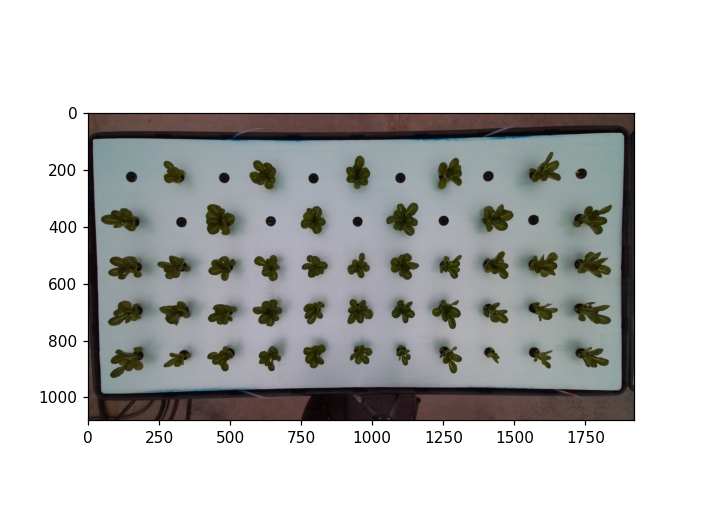

In [4]:
# PCV is reading this img as BGR instead of RGB
raw_img, path, img_filename = pcv.readimage(filename=path, mode="native")
# pcv.plot_image(raw_img)

## Add bigger contour instead of cropping the image

<IPython.core.display.Javascript object>


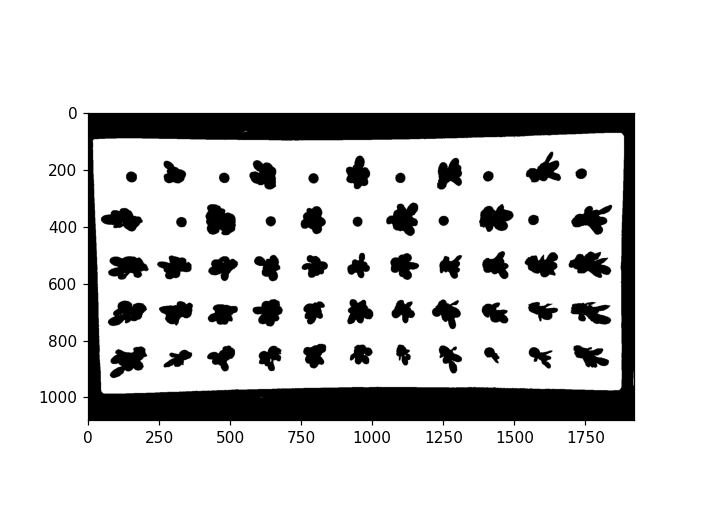

<IPython.core.display.Javascript object>


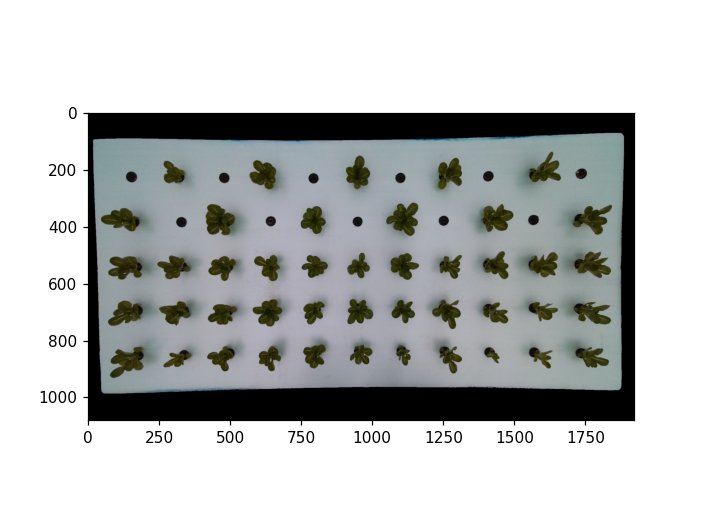

In [11]:
black = np.zeros(raw_img.shape).astype(raw_img.dtype)


#img = cv2.resize(img, (2000, 1400))            # Resize image
img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)  # change the colouring


# Definition of blue color around plate
lower = [0 , 0, 110]  # plates 60, 31, 165
higher = [255, 255, 255]
lower = np.array(lower, dtype = "uint8")
higher = np.array(higher, dtype = "uint8")

# Picture cropping
raft_mask = cv2.inRange(img,lower,higher)# Make a mask
pcv.plot_image(raft_mask)
cont, _ = cv2.findContours(raft_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) # search for contours
#print(cont[1])
cont = sorted(cont,key=cv2.contourArea)
#print(cont[-1])
#cont_img = cv2.drawContours(img,cont,-1,(0,0,255),0)
#cont = np.array([[50, 50], [50, 150], [150, 150], [150, 50]])

cv2.fillPoly(black, pts = [cont[-1]], color=[255,255,255])
#cv2.drawContours(img, cont[-1], -1, color=(255, 255, 255), thickness=cv2.FILLED)
img_crop = cv2.bitwise_and(img, black)
img_crop = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)  # change the colouring
pcv.plot_image(result)

## Cropping image instead of using biggest contour approach

<IPython.core.display.Javascript object>


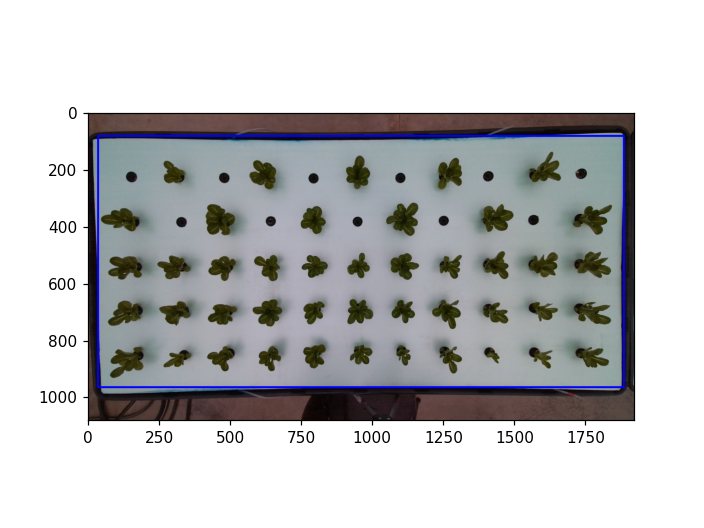

In [39]:
# (X and Y are starting X,Y coordinate respectively)
# h = y_axis total lenght , w = x_axis total lenght
#img = pcv.crop(img=raw_img, x=35, y=80, h=885, w=1850)

## Step 2: Image Thresholding (BOTTLENECK WARNING)

<IPython.core.display.Javascript object>


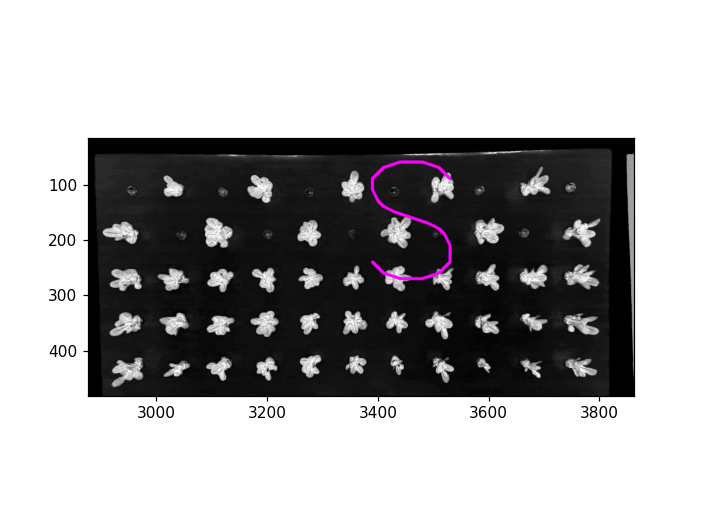

In [12]:
colorspace_img = pcv.visualize.colorspaces(rgb_img=img_crop,original_img=True)

<IPython.core.display.Javascript object>


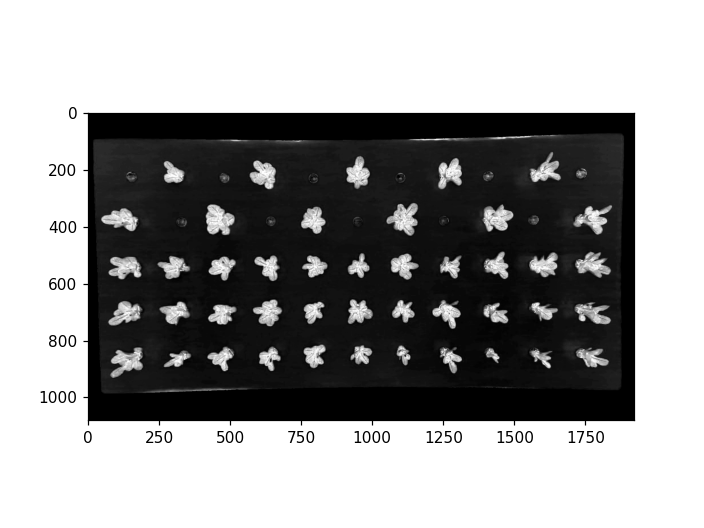

In [32]:
#   channel = desired colorspace ('l', 'a', or 'b')
hsv_s = pcv.rgb2gray_hsv(rgb_img=img_crop, channel='s')
#pcv.plot_image(hsv_s)

<IPython.core.display.Javascript object>


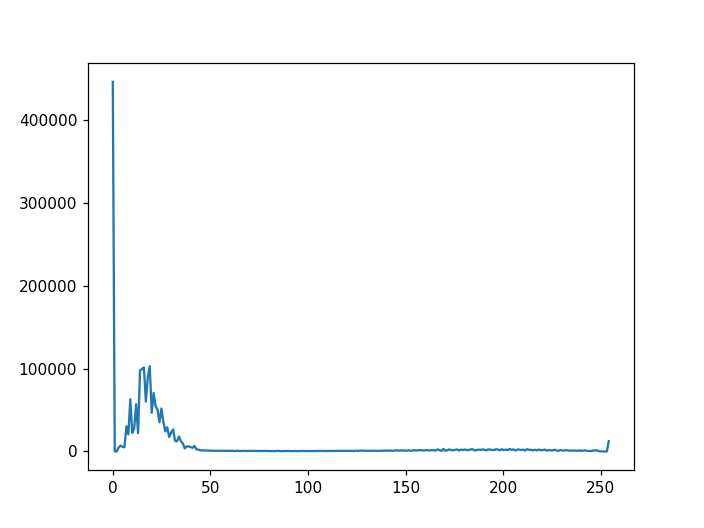

In [33]:
histogram, bin_edges = np.histogram(hsv_s, bins=256, range=(0, 255))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)

<IPython.core.display.Javascript object>


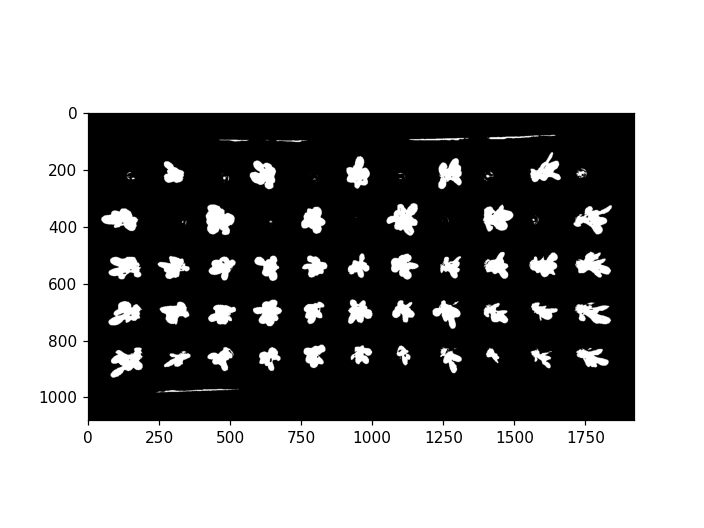

In [41]:
# The pixel intensities on the right side of the threshold represent our objects (binary value to 1)
thresh = pcv.threshold.binary(gray_img=hsv_s, threshold=100, max_value=255, object_type='light')
#pcv.plot_image(thresh)

<IPython.core.display.Javascript object>


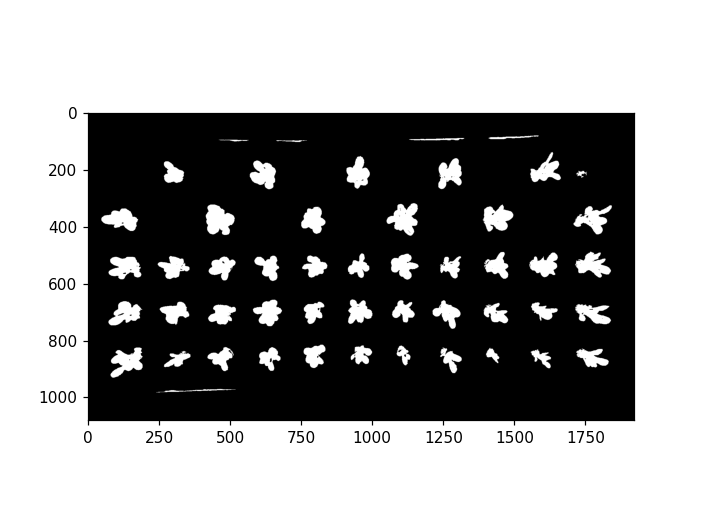

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [52]:
# fills (deletes) objects that are less than specified size 
h_fill = pcv.fill(bin_img=thresh, size=300)
# pcv.plot_image(h_fill)
print(h_fill)

## Step 3: Object Identification (Bottleneck Warning)
The specific part of the code that is giving us issues here is the multiple regions of interest creation. 
- Could we just identify the objects and enumerate each individual object from 1 till the total amount of objects identified? 

<IPython.core.display.Javascript object>


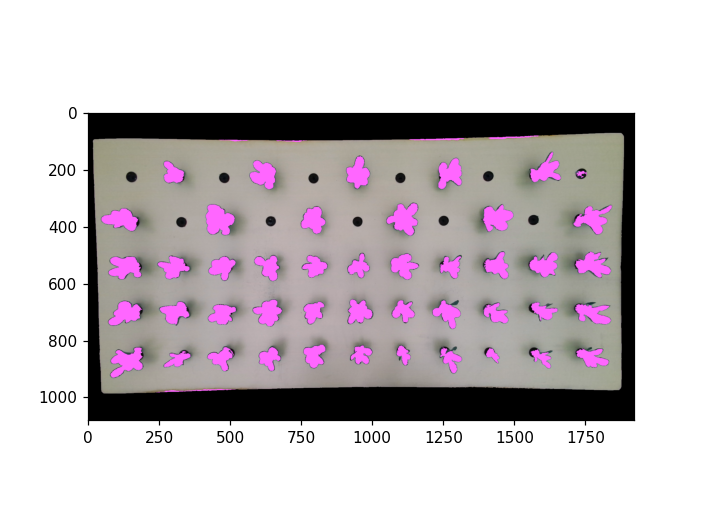

[array([[[464, 970]],

       [[463, 971]],

       [[462, 971]],

       ...,

       [[467, 971]],

       [[466, 971]],

       [[465, 971]]], dtype=int32), array([[[444, 974]],

       [[445, 973]],

       [[446, 974]],

       [[445, 975]]], dtype=int32), array([[[335, 837]],

       [[335, 838]],

       [[334, 839]],

       [[333, 839]],

       [[332, 840]],

       [[331, 839]],

       [[330, 838]],

       [[330, 839]],

       [[330, 840]],

       [[331, 841]],

       [[331, 842]],

       [[332, 843]],

       [[332, 844]],

       [[331, 845]],

       [[330, 844]],

       [[329, 844]],

       [[328, 844]],

       [[327, 844]],

       [[326, 844]],

       [[325, 844]],

       [[324, 844]],

       [[323, 844]],

       [[322, 845]],

       [[323, 845]],

       [[324, 845]],

       [[325, 846]],

       [[326, 846]],

       [[327, 847]],

       [[326, 848]],

       [[325, 848]],

       [[324, 848]],

       [[323, 848]],

       [[322, 848]],

       [[321

In [46]:
obj, obj_hierarchy = pcv.find_objects(img=img_crop, mask=h_fill)
type(obj)
print(obj)

### HERE IS THE CONFLICTING STEP: LOOK AN ALTERNATIVE FOR THIS!

<IPython.core.display.Javascript object>


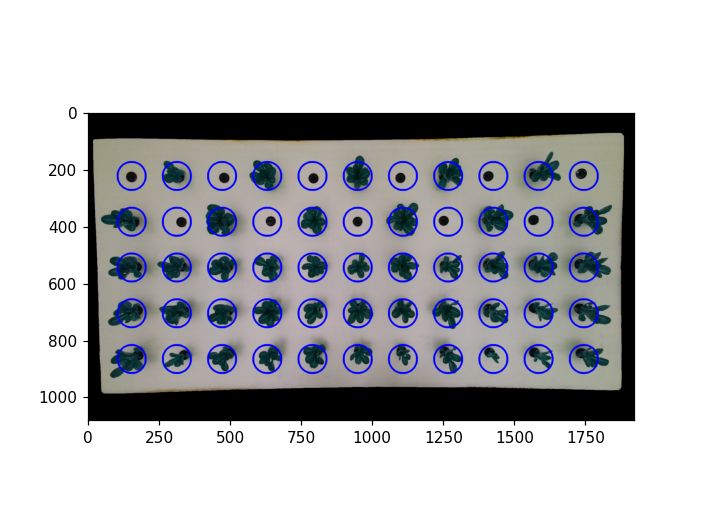

[(array([[[153, 171]],

       [[152, 172]],

       [[151, 172]],

       [[150, 172]],

       [[149, 172]],

       [[148, 172]],

       [[147, 172]],

       [[146, 172]],

       [[145, 172]],

       [[144, 172]],

       [[143, 173]],

       [[142, 173]],

       [[141, 173]],

       [[140, 173]],

       [[139, 173]],

       [[138, 174]],

       [[137, 174]],

       [[136, 174]],

       [[135, 175]],

       [[134, 175]],

       [[133, 176]],

       [[132, 176]],

       [[131, 177]],

       [[130, 177]],

       [[129, 178]],

       [[128, 178]],

       [[127, 179]],

       [[126, 179]],

       [[125, 180]],

       [[124, 181]],

       [[123, 181]],

       [[122, 182]],

       [[121, 183]],

       [[120, 184]],

       [[119, 185]],

       [[118, 186]],

       [[117, 187]],

       [[116, 188]],

       [[115, 189]],

       [[114, 190]],

       [[113, 191]],

       [[113, 192]],

       [[112, 193]],

       [[111, 194]],

       [[111, 195]],

       [

In [48]:
rois, roi_hierarchy = pcv.roi.multi(img=img_crop, coord=(153,221), radius=50, 
                                    spacing=(159, 161), nrows=5, ncols=11)
print(rois)
print(roi_hierarchy)

Check the plant ids generated if you want to make sure the rois is selecting all our plants in the grid. Usually,  when pixels  are far away from each other it will generate 2 different plant id's. 

In [50]:
plant_ids = range(0, len(rois))
print(plant_ids)

range(0, 55)


In [52]:
# Here we create a copy of the original img image
img_copy = np.copy(img)

<IPython.core.display.Javascript object>


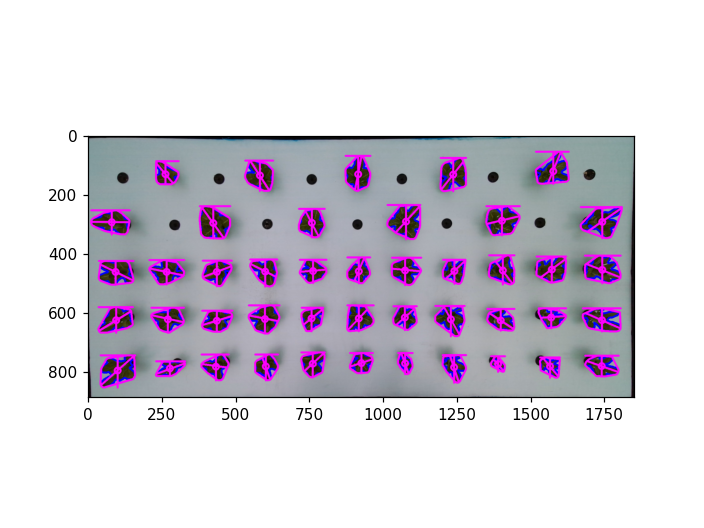

In [53]:
# Set debug to None (plotting all of the images would be very verbose output)
pcv.params.debug = None

# Create a for loop to interate through every ROI (plant) in the image
for i in range(0, len(rois)):
    # The ith ROI, ROI hierarchy, and plant ID
    roi = rois[i]
    hierarchy = roi_hierarchy[i]
    plant_id = plant_ids[i]
    # Subset objects that overlap the ROI
    # Inputs:
    #   img            = input image
    #   roi_contour    = a single ROI contour
    #   roi_hierarchy  = a single ROI hierarchy
    #   object_contour = all objects detected in a binary mask
    #   obj_hierarchy  = all object hierarchies
    #   roi_type       = "partial" (default) keeps contours that overlap
    #                    or are contained in the ROI. "cutto" cuts off
    #                    contours that fall outside the ROI. "largest"
    #                    only keeps the largest object within the ROI
    plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=img, 
                                                                  roi_contour=roi, 
                                                                  roi_hierarchy=hierarchy, 
                                                                  object_contour=obj, 
                                                                  obj_hierarchy=obj_hierarchy, 
                                                                  roi_type="partial")

    # If the plant area is zero then no plant was detected for the ROI
    # and no measurements can be done
    if area > 0:
        # Combine contours together for each plant
        # Inputs:
        #   img       = input image
        #   contours  = contours that will be consolidated into a single object
        #   hierarchy = the relationship between contours
        plant_obj, plant_mask = pcv.object_composition(img=img, 
                                                       contours=plant_contours, 
                                                       hierarchy=plant_hierarchy)       
        # Analyze the shape of each plant
        # Inputs:
        #   img   = input image
        #   obj   = composed object contours
        #   mask  = binary mask that contours were derived from
        #   label = a label for the group of measurements (default = "default")
        img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                      mask=plant_mask, label=f"plant{plant_id}")
        

pcv.plot_image(img_copy)

In [54]:
# I'm storing all observations from the output as a dictionary to index values from that dictionary
plant_data = pcv.outputs.observations
print(plant_data)

{'plant1': {'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4012.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4504.5, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.8906648906648906, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 294.1076455116272, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>",

In [63]:
data_parameters = {}
for key in plant_data['plant1'].keys():
  data_parameters['plant_'+ key] = []
  for plant in plant_data.keys():
     data_parameters['plant_'+ key].append(plant_data[plant][key]['value'])
    
    
plant_observation = list(plant_data.keys())
data_set = pd.DataFrame(data_parameters)
# I'm adding a new column with the identification for each plant. Insert plant id at the beginning
data_set.insert(0, 'plant_id', plant_observation)
data_set.insert(len(data_set.columns), 'total_plants', len(rois))

print(data_set)

   plant_id  plant_in_bounds  plant_area  plant_convex_hull_area  \
0    plant1             True      4012.0                  4504.5   
1    plant3             True      6780.0                  7336.0   
2    plant5             True      6299.0                  7141.0   
3    plant7             True      6631.0                  7895.5   
4    plant9             True      6368.0                  8421.5   
5   plant11             True      6698.0                  7393.0   
6   plant13             True      8362.0                  8966.5   
7   plant15             True      5709.0                  6221.5   
8   plant17             True      8242.0                  9589.5   
9   plant19             True      7508.0                  8532.0   
10  plant21             True      7352.0                  9795.0   
11  plant22             True      6890.0                  8054.5   
12  plant23             True      5513.0                  6680.0   
13  plant24             True      5112.0        